<a href="https://colab.research.google.com/github/white0825/2022S-ML/blob/main/baseline_201820750_%EB%B0%B1%EB%AF%BC%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge :: Cartoon Character Classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


만화 이미지를 보고 어떤 캐릭터인지를 분류하는 테스크입니다.  
캐릭터 클래스는 총 10개 입니다.

## Download Data
데이터 출처: https://www.kaggle.com/datasets/volkandl/cartoon-classification

코랩에서 캐글 데이터셋을 바로 불러오기 위해서 kaggle.json 파일이 필요합니다.  
```캐글 본인 계정 페이지``` -> ```Account``` -> ```API``` -> ```Create New API Token```
로 kaggle.json 파일을 다운로드 받을 수 있습니다.

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"white0825","key":"43dd60bcaed752d2911b6cc54ddbbbc5"}'}

In [ ]:
ls -1ha kaggle.json # kaggle.json 확인

kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d volkandl/cartoon-classification

100% 11.5G/11.5G [01:22<00:00, 119MB/s]
100% 11.5G/11.5G [01:22<00:00, 151MB/s]


In [ ]:
!ls # 데이터셋 다운로드 확인

cartoon-classification.zip  drive  kaggle.json	sample_data


In [ ]:
!unzip cartoon-classification.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5099.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY51.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY510.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5100.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5101.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5102.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5103.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5104.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5105.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5106.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5107.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5108.jpg  
  infla

## Load Data

In [ ]:
#Load data
from keras.preprocessing.image import ImageDataGenerator
# 학습에 사용될 이미지 데이터 생성기
train_datagen = ImageDataGenerator(rescale= 1. /255)
 
# 검증에 사용될 이미지 데이터 생성기
test_datagen = ImageDataGenerator(rescale= 1. /255)

batch_size = 32
image_size = 224
train_dir='./cartoon_classification/' + "TRAIN"
test_dir='./cartoon_classification/' + "TEST"

# 학습에 사용될 데이터 생성기  
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

# 검증에 사용될 데이터 생성기
test_generator = test_datagen.flow_from_directory(
       test_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_num=len(train_generator.class_indices)

custom_labels = list(test_generator.class_indices.keys())

print(custom_labels)

Found 119617 images belonging to 10 classes.
Found 18110 images belonging to 10 classes.
['Familyguy', 'Gumball', 'Tsubasa', 'adventure_time', 'catdog', 'pokemon', 'smurfs', 'southpark', 'spongebob', 'tom_and_jerry']


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
import torch.utils.data


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True # prevent truncate error

In [ ]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((600, 600)),
        transforms.ToTensor(),
        
    ]),
    "test": transforms.Compose([
        transforms.Resize((600, 600)),
        transforms.ToTensor(),
    ])
}

In [ ]:
# From https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [ ]:
train_data = ImageFolderWithPaths(root = './cartoon_classification/' + "TRAIN", # load train data
                                   transform = image_transforms["train"]
                                  )
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True) # make train loader

In [ ]:
test_data = ImageFolderWithPaths(root = './cartoon_classification/' + "TEST",
                                   transform = image_transforms["test"] # load test data
                                  )
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False ) # make test loader 
# shuffle false 로 하지 않으면 서버에서 테스트 할 때 문제 생김

In [ ]:
classes = train_data.class_to_idx # class name
classes

{'Familyguy': 0,
 'Gumball': 1,
 'Tsubasa': 2,
 'adventure_time': 3,
 'catdog': 4,
 'pokemon': 5,
 'smurfs': 6,
 'southpark': 7,
 'spongebob': 8,
 'tom_and_jerry': 9}

## Show Example Data

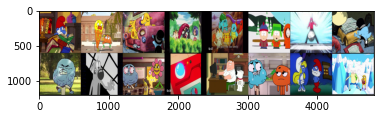


smurfs Gumball catdog pokemon pokemon southpark Tsubasa catdog Gumball catdog Gumball pokemon Familyguy Gumball smurfs adventure_time


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels, paths = dataiter.next()

batch_size = 16

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print()
labels = labels.tolist()
print(' '.join(f'{list(classes.keys())[list(classes.values()).index(j)]}' for j in labels))

## Define a Convolutional Neural Network

Modified https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Keras CNN

In [ ]:
#Keras CNN model 생성
#참고
# https://chancoding.tistory.com/92
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.layers import *
from sklearn.metrics import accuracy_score

model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), padding='same',
                input_shape=(224,224,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3,3),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU if it's available

## Define a Loss function and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # optimizer

## Train the Network

In [ ]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, 
                    epochs=1, batch_size=32)

Epoch 1/2
3739/3739 [==============================] - 719s 192ms/step - loss: 0.0241 - accuracy: 0.9938
Epoch 2/2
3739/3739 [==============================] - 721s 193ms/step - loss: 0.0189 - accuracy: 0.9957


## Save the Network

In [ ]:
PATH = 'drive/MyDrive/ML/keras_net.h5'
model.save(PATH)

## Load the Network

In [ ]:
model.load(PATH)

<All keys matched successfully>

## Testing & Making a Submission File

In [ ]:
test_loss, test_acc=model.evaluate(test_generator)

print('\ntest_acc :', test_acc, 'test_loss', test_loss)

566/566 [==============================] - 177s 314ms/step - loss: 4.4486 - accuracy: 0.6851

test_acc : 0.6851463317871094 test_loss 4.4486260414123535


In [ ]:
predict = model.predict(test_generator)

In [ ]:
prediction=[]
for data in predict:
  data_t=data.tolist()
  prediction.append(data_t.index(max(data_t)))

In [ ]:
image_id = []

with torch.no_grad():
    for i, data in enumerate(tqdm(test_loader,0)):
        images, labels, paths = data
        
        image_id.append(paths)

  0%|          | 0/18110 [00:00<?, ?it/s]

In [ ]:
submit_sol = pd.DataFrame(list(zip(image_id, prediction)), columns=['id','predicted'])

In [ ]:
submit_sol

,id,predicted
0,Familyguy/family_guy100.jpg,1
1,Familyguy/family_guy10000.jpg,4
2,Familyguy/family_guy10001.jpg,4
3,Familyguy/family_guy10002.jpg,4
4,Familyguy/family_guy10003.jpg,4
...,...,...
18105,tom_and_jerry/TOM_AND_JERRY9995.jpg,9
18106,tom_and_jerry/TOM_AND_JERRY9996.jpg,9
18107,tom_and_jerry/TOM_AND_JERRY9997.jpg,9
18108,tom_and_jerry/TOM_AND_JERRY9998.jpg,9


In [ ]:
import os

def clean_path(path):
  cleaned_path = os.path.normpath(path)
  cleaned_path = path.split(os.sep)
  new_path = cleaned_path[3] +'/' + cleaned_path[4] # cartoon name/xx.jpg
  return new_path

In [ ]:
path_list = []
for i in range(len(submit_sol)):
  out = clean_path(submit_sol.iloc[i][0][0])
  path_list.append(out)

submit_sol['id'] = path_list

In [ ]:
submit_sol.to_csv('test_result.csv', index=False)  # submit this test_result.csv to kaggle server